# Investigating the role of pre-miRNA concentration on competition

Using same model as for the investigations into the competition effects between 8 theoretical pre-miRNAs

## Set up workspace

In [1]:
import model_utils as mu
import params
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm
import seaborn as sns
import matplotlib.style as style
style.use('seaborn-colorblind')

In [2]:
destdir_csvs = './outputs/premir-conc-vars/csvs/'
destdir_figs = './outputs/premir-conc-vars/plots/'

## Generate model

In [3]:
#make 2 miRNA model
ODE_inits = [0]*8*4 + [0]
ODE_ka = [0] * 8
ODE_kb = ODE_ka
ODE_kc = ODE_ka
ODE_kd = ODE_ka

In [4]:
ode = mu.makeODEs(ODE_inits, ODE_ka, ODE_kb, ODE_kc, ODE_kd)

In [5]:
model = mu.makeModel(ode)

## Set up conditions for models

In [6]:
high = 10
low = 1
k = 2

In [7]:
inits1 = [params.init_pMiR1, params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, params.init_MiR1] * 8

In [8]:
ka = [params.ka1 * high, params.ka1 * low] + [params.ka1] * 2 +\
     [params.ka1 * high * k, params.ka1 * low] + [params.ka1 * k] * 2

kb = [params.ka1 * params.Kd_wt, params.ka1 * params.Kd_wt * high]  + \
    [params.ka1 * params.Kd_wt] * 2 + \
    [params.ka1 * params.Kd_wt, params.ka1 * params.Kd_wt * high * k] +\
    [params.ka1 * params.Kd_wt] * 2

kc = [params.kc1] * 2 + [params.kc1 * high, params.kc1] + \
     [params.kc1] * 2 + [params.kc1 * high * k, params.kc1]

kd = [params.kd] * 3 + [params.kd * high] + [params.kd] * 3 + [params.kd * high * k]

In [9]:
#Dicer concentration variations
dvars = np.linspace(0, 7.25, 15)
dvars[0] = 0.01
dvars = np.append(dvars, np.linspace(10, 15, 4))
variations = [str(int(i * 100)) for i in list(dvars)]

In [10]:
#pre-miRNA concentration variations
pvars = np.linspace(0, 1, 5)
pvars = np.append(pvars, np.linspace(1.5, 5, 8))
p_variations = [str(int(i*100)) for i in list(dvars)]

## Run model, save outputs

In [11]:
exec(model)

In [12]:
names = []
for ii in tqdm(range(len(dvars))):
    for ij in range(0, int(8*4), 4):
        for ik in range(len(pvars)):
            name = 'model_d' + variations[ii] + '_miR' + str(int(ij/4)) + '_' + p_variations[ik]
            
            init = inits1 + [dvars[ii]]
            init[ij] = init[ij] * pvars[ik]
            
            res = solve_ivp(runModel, (0, int(params.minutes)), init, \
                            args = (ka, kb, kc, kd), method = 'LSODA')
    
            mirna_length = int((len(res.y)-1)/4)
            index = []
    
            for j in range(mirna_length):
                index = index + ['pMiR' + str(j), 'pMiR_dicer' + str(j), \
                                 'pMiR_dicer_star' + str(j), 'miR' + str(j)]
    
            index = index + ['dicer']
    
            df = pd.DataFrame(res.y, index = index)
            df = df.transpose()
            df.insert(loc = 0, column = 'time_min', value = res.t)
    
            names.append(name)
    
            df.to_csv(destdir_csvs + name + '.csv', index = False)

df1 = pd.DataFrame({'names': names})
df1.to_csv(destdir_csvs + 'names.csv', index = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:58<00:00,  3.05s/it]


In [11]:
names = pd.read_csv(destdir_csvs + 'names.csv')
names = list(names['names'])

In [12]:
#prep data for plotting
##read data
for name in tqdm(names):
    exec(name + ' = pd.read_csv("' + destdir_csvs + name + '.csv", header = [0])')

100%|██████████| 1976/1976 [00:30<00:00, 65.40it/s]


In [13]:
#prep end points for plotting
##[pMiR that's varied][pMiR concentrations][Dicer concentrations]
ends = {'miR0_changed': np.zeros((8, len(pvars), len(dvars))), 'miR1_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR2_changed': np.zeros((8, len(pvars), len(dvars))), 'miR3_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR4_changed': np.zeros((8, len(pvars), len(dvars))), 'miR5_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR6_changed': np.zeros((8, len(pvars), len(dvars))), 'miR7_changed': np.zeros((8, len(pvars), len(dvars)))}


for k in tqdm(range(8)):
    for j in range(len(pvars)):
        for i in range(len(dvars)):
            exec('miR = model_d' + variations[i] + '_miR' + str(k) + '_' + p_variations[j])
            ends['miR' + str(k) + '_changed'][0][j][i] = miR['miR0'].iloc[-1]
            ends['miR' + str(k) + '_changed'][1][j][i] = miR['miR1'].iloc[-1]
            ends['miR' + str(k) + '_changed'][2][j][i] = miR['miR2'].iloc[-1]
            ends['miR' + str(k) + '_changed'][3][j][i] = miR['miR3'].iloc[-1]
            ends['miR' + str(k) + '_changed'][4][j][i] = miR['miR4'].iloc[-1]
            ends['miR' + str(k) + '_changed'][5][j][i] = miR['miR5'].iloc[-1]
            ends['miR' + str(k) + '_changed'][6][j][i] = miR['miR6'].iloc[-1]
            ends['miR' + str(k) + '_changed'][7][j][i] = miR['miR7'].iloc[-1]

100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


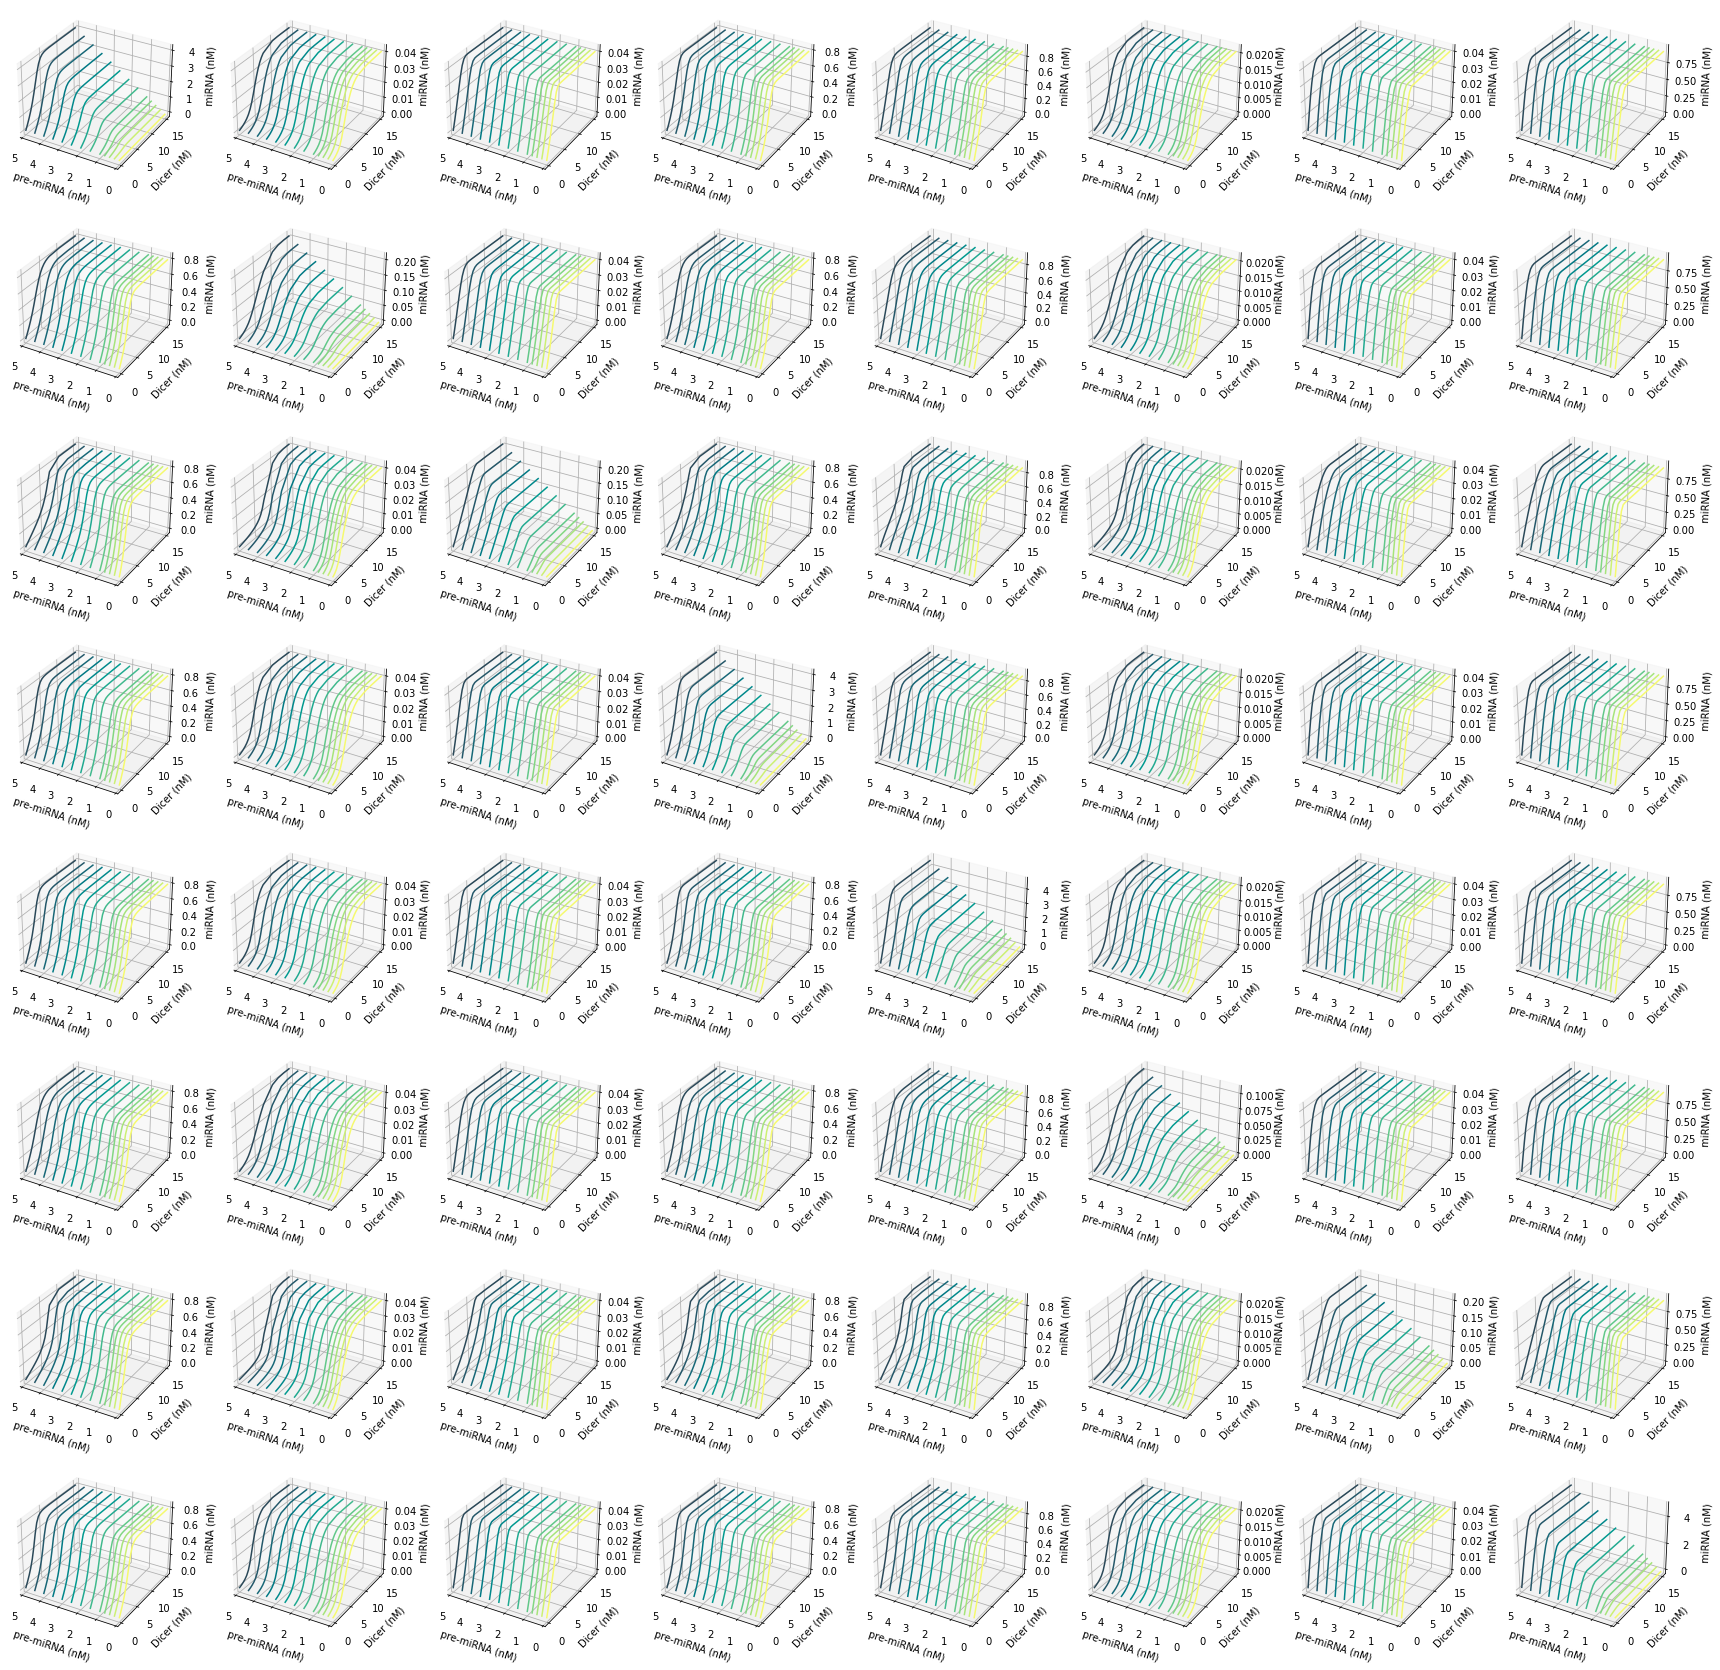

In [14]:
#plot 3d plots
fig = plt.figure(figsize = (30,30))

color_gradient = ["#f5fa6e", "#ccf073", "#a6e47a", "#82d781", "#61c888", "#40b98d", "#1fa990",
                  "#00998f", "#00888b", "#007883", "#176777", "#245769", "#2a4858"]

plot_ixs = np.arange(8*8).reshape((8,8))
plot_ixs = plot_ixs + np.ones((8,8))

for i in range(8):
    for j in range(8):
        exec('ax' + ' = fig.add_subplot(8, 8, ' + str(int(plot_ixs[i][j])) + ', projection = "3d")')
        
        for k in range(len(pvars)):
            ax.plot(dvars,
                    ends['miR' + str(i) + '_changed'][j][k],
                    pvars[k],
                    color = color_gradient[k])
            ax.set_xlabel('Dicer (nM)')
            ax.set_ylabel('miRNA (nM)')
            ax.set_zlabel('pre-miRNA (nM)')
            ax.invert_zaxis()
            ax.view_init(vertical_axis = 'y')

#along x-axis: affected miRNA
#along y-axis: changed pre-miRNA

plt.savefig(destdir_figs + 'all_mirnas_matrix.svg', dpi = 600, bbox_inches = 'tight')

plt.show()
                

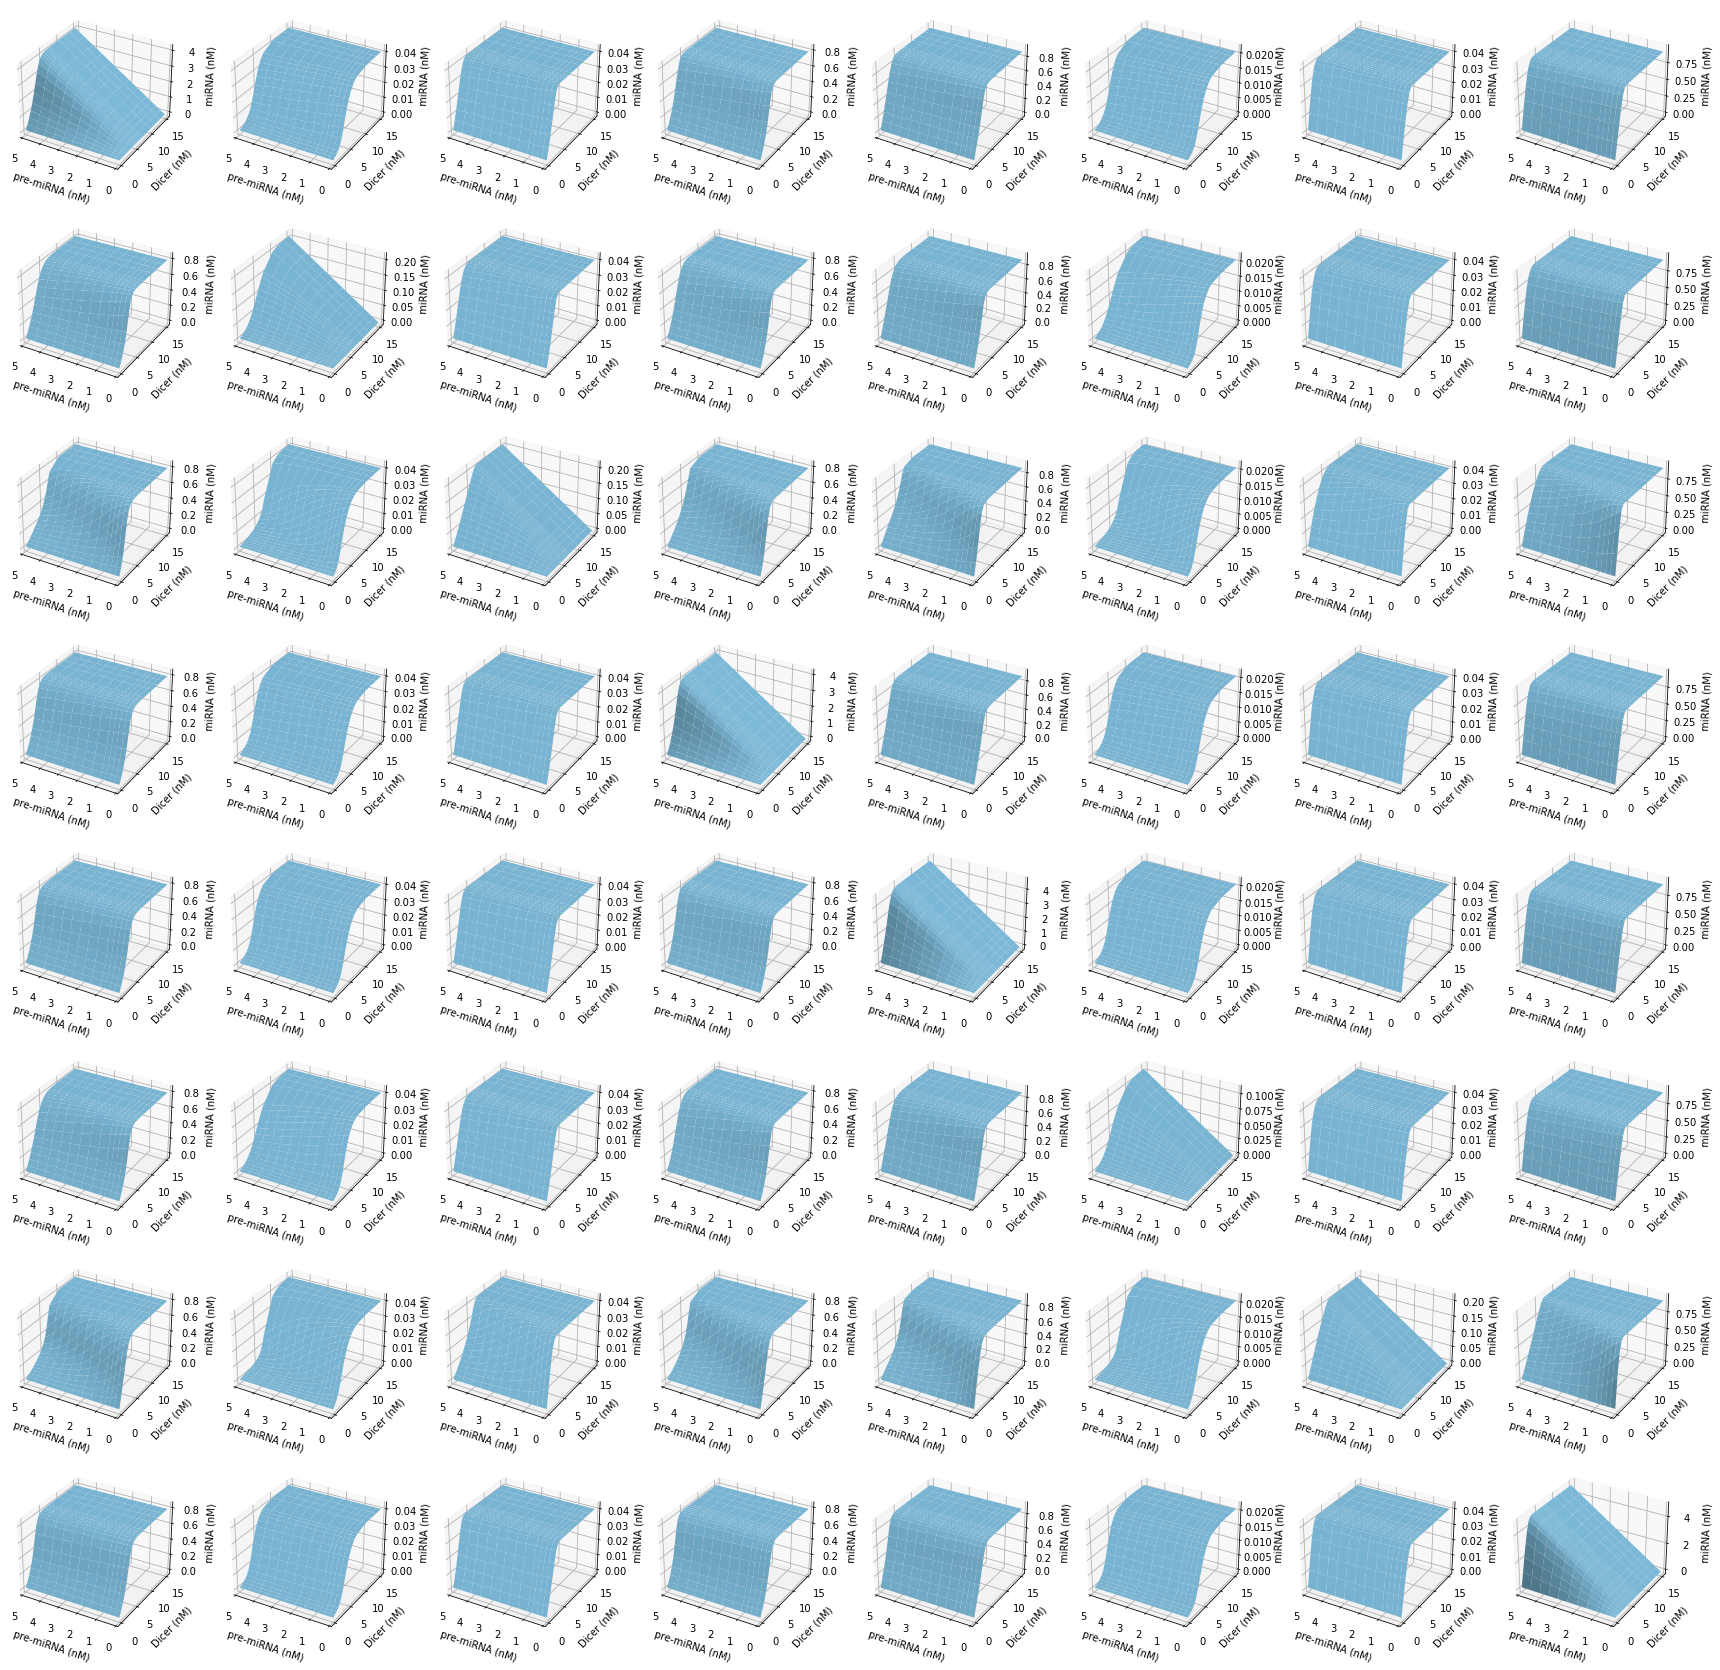

In [15]:
#plot 3d plots
fig = plt.figure(figsize = (30,30))
plot_ixs = np.arange(8*8).reshape((8,8))
plot_ixs = plot_ixs + np.ones((8,8))

for i in range(8):
    for j in range(8):
        exec('ax' + ' = fig.add_subplot(8, 8, ' + str(int(plot_ixs[i][j])) + ', projection = "3d")')
        
        x = dvars
        z = pvars
        x, z = np.meshgrid(x, z)
        y = ends['miR' + str(i) + '_changed'][j]
        ax.plot_surface(x,
                y,
                z,
                color = params.colors[0][1])
        ax.set_xlabel('Dicer (nM)')
        ax.set_ylabel('miRNA (nM)')
        ax.set_zlabel('pre-miRNA (nM)')
        ax.invert_zaxis()
        ax.view_init(vertical_axis = 'y')

#along x-axis: affected miRNA
#along y-axis: changed pre-miRNA

plt.savefig(destdir_figs + 'all_mirnas_matrix-surface.svg', dpi = 600, bbox_inches = 'tight')

plt.show()
                

In [63]:
#dictionary to hold topological distortion values
top_dist = {}
#centre of projection
COP = np.array([0, 0, 0])
for i in range(8): #miRNA that's changed
    top_dist['miR' + str(i) + '_changed'] = np.zeros((8, len(pvars), len(dvars)))
    for j in range(8): #miRNA that's affected
        for k in range(len(pvars)): #initial pre-miRNA concentration
            for l in range(len(dvars)): #Dicer concentration
                #find coordinates in point
                coord = np.array([dvars[l], ends['miR' + str(i) + '_changed'][j][k][l], pvars[k]])
                #find matrix norms to COP
                top_dist['miR' + str(i) + '_changed'][j][k][l] = np.linalg.norm(coord - COP)

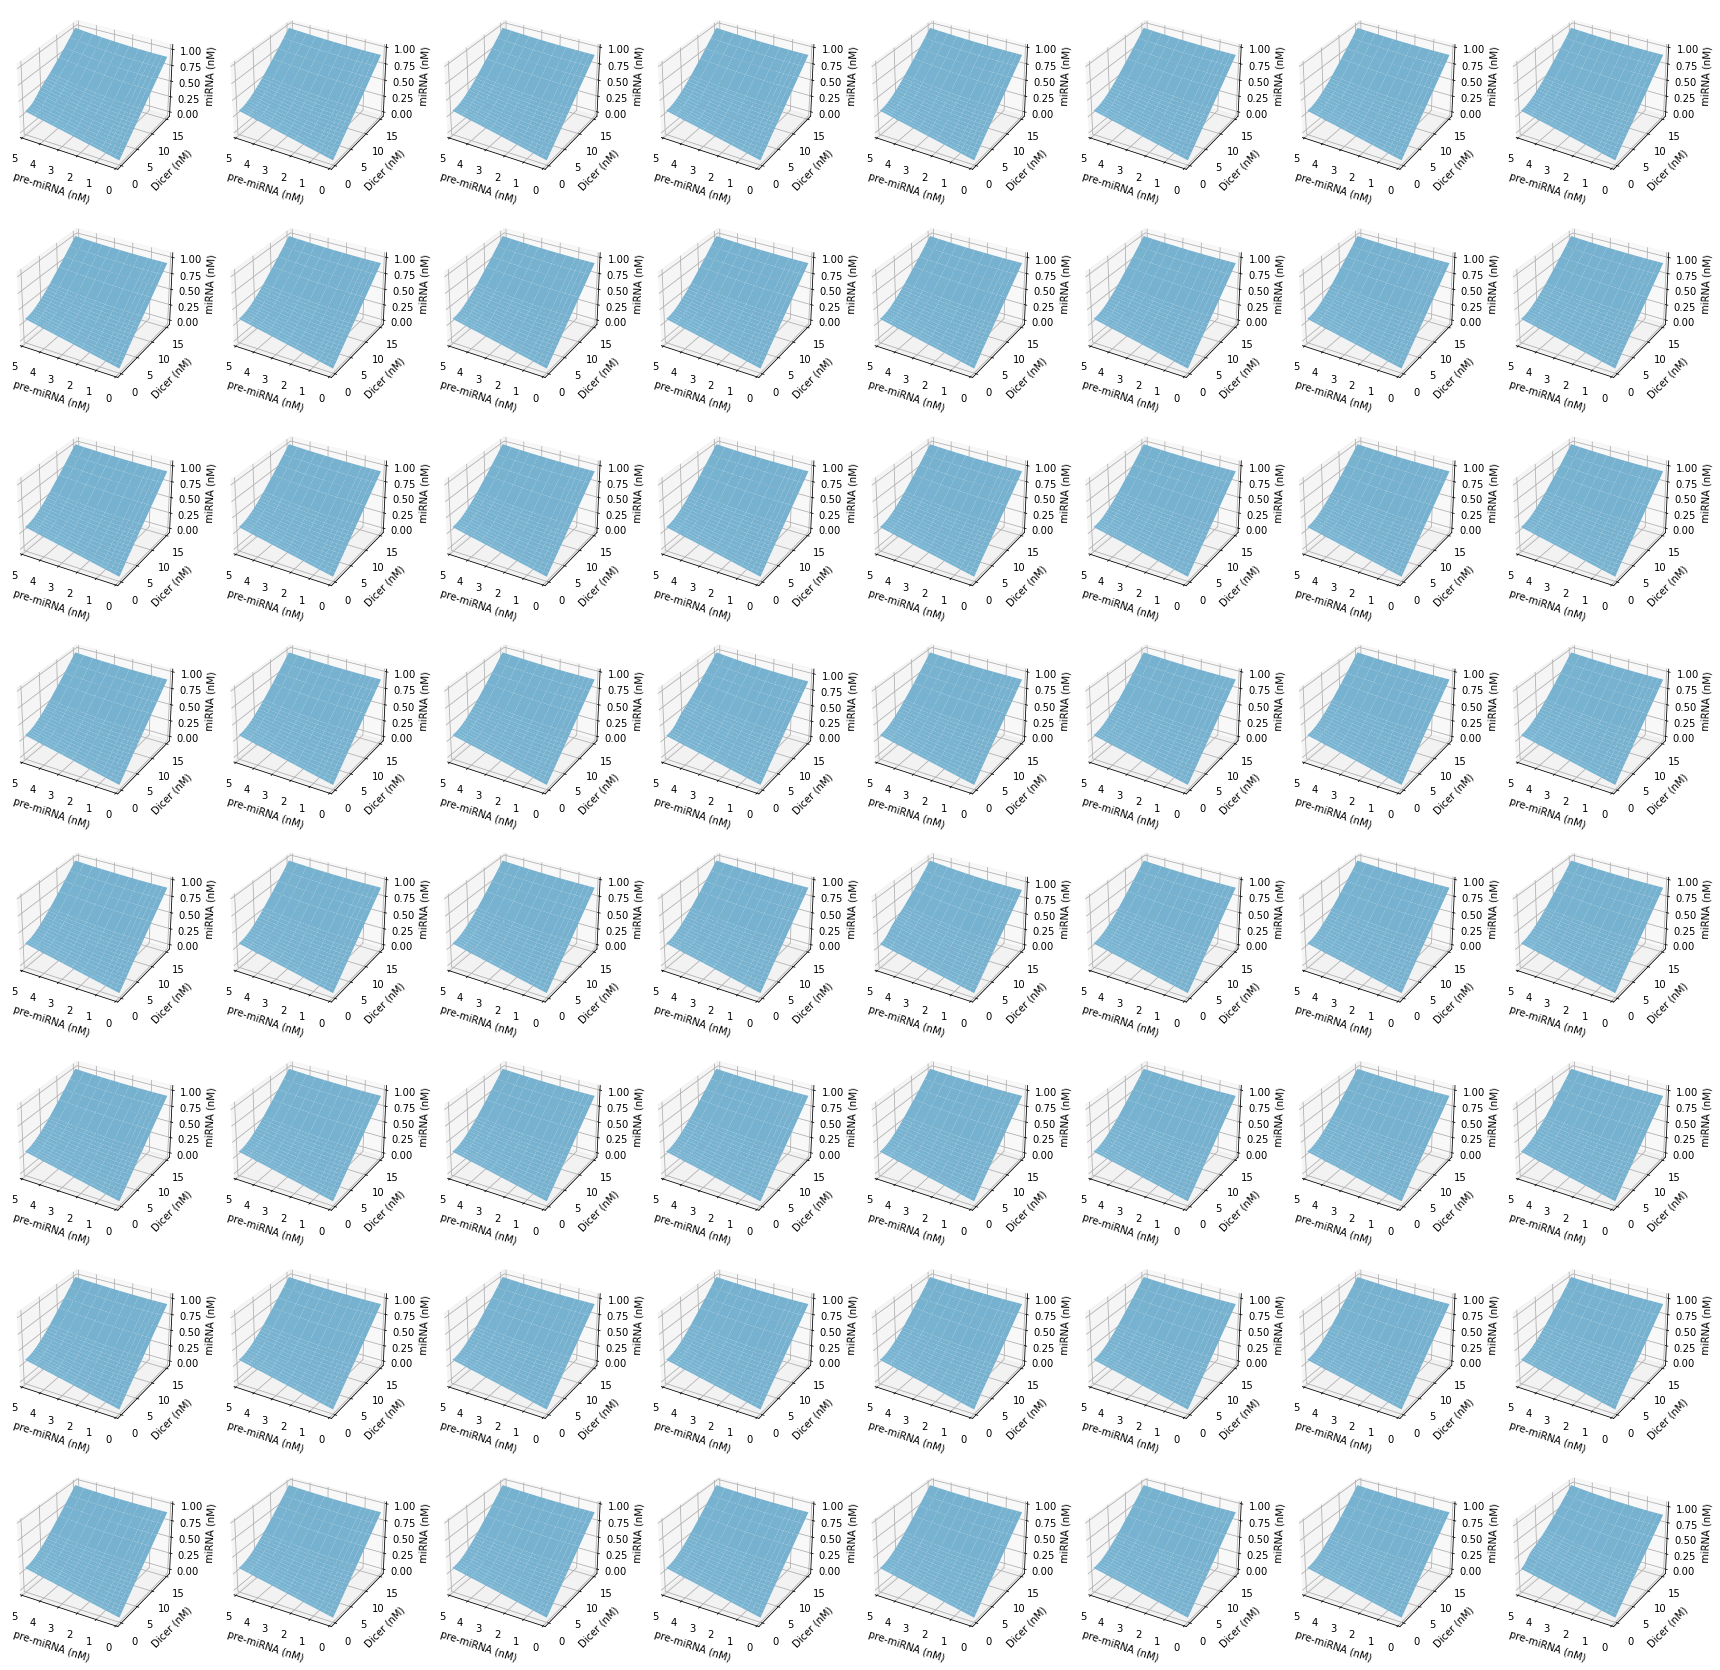

In [68]:
fig = plt.figure(figsize = (30,30))
plot_ixs = np.arange(8*8).reshape((8,8))
plot_ixs = plot_ixs + np.ones((8,8))

for i in range(8):
    for j in range(8):
        exec('ax' + ' = fig.add_subplot(8, 8, ' + str(int(plot_ixs[i][j])) + ', projection = "3d")')
        
        x = dvars
        z = pvars
        x, z = np.meshgrid(x, z)
        y = top_dist['miR' + str(i) + '_changed'][j]
        ax.plot_surface(x,
                y,
                z,
                color = params.colors[0][1])
        ax.set_xlabel('Dicer (nM)')
        ax.set_ylabel('miRNA (nM)')
        ax.set_zlabel('pre-miRNA (nM)')
        ax.invert_zaxis()
        ax.view_init(vertical_axis = 'y')
        
plt.show()

In [64]:
#normalise matrix norms across all miRNAs
top_normd = top_dist
for key in top_dist:
    top_normd[key] = top_dist[key] / np.max(top_dist[key])

In [65]:
#find mean
mean_distortion = np.zeros((8,8))
index = list(top_normd.keys())
colnames = []

for i in range(len(index)):
    arr = top_normd[index[i]]
    for j in range(len(arr)):
        mean_distortion[i][j] = np.mean(arr)
    colnames.append('miR' + str(i))

In [66]:
#create pandas df
dist_df = pd.DataFrame(mean_distortion, columns = colnames, index = index)
dist_df

miR0      miR1      miR2      miR3      miR4      miR5  \
miR0_changed  0.391490  0.391490  0.391490  0.391490  0.391490  0.391490   
miR1_changed  0.402126  0.402126  0.402126  0.402126  0.402126  0.402126   
miR2_changed  0.402018  0.402018  0.402018  0.402018  0.402018  0.402018   
miR3_changed  0.391649  0.391649  0.391649  0.391649  0.391649  0.391649   
miR4_changed  0.389386  0.389386  0.389386  0.389386  0.389386  0.389386   
miR5_changed  0.402125  0.402125  0.402125  0.402125  0.402125  0.402125   
miR6_changed  0.402003  0.402003  0.402003  0.402003  0.402003  0.402003   
miR7_changed  0.388381  0.388381  0.388381  0.388381  0.388381  0.388381   

                  miR6      miR7  
miR0_changed  0.391490  0.391490  
miR1_changed  0.402126  0.402126  
miR2_changed  0.402018  0.402018  
miR3_changed  0.391649  0.391649  
miR4_changed  0.389386  0.389386  
miR5_changed  0.402125  0.402125  
miR6_changed  0.402003  0.402003  
miR7_changed  0.388381  0.388381

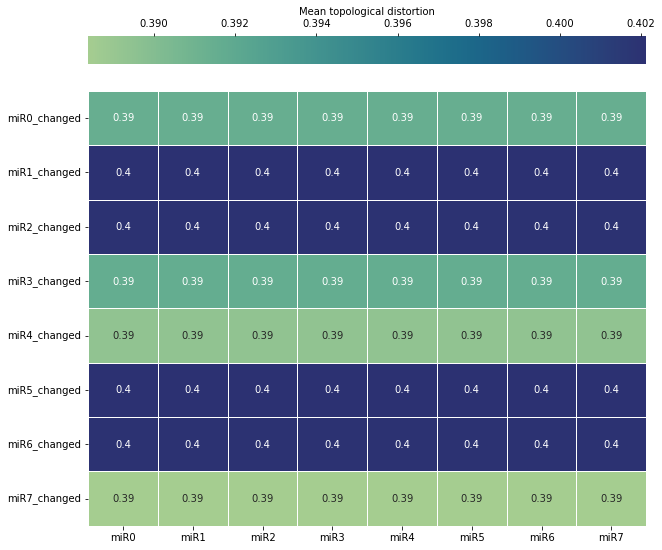

In [67]:
fig = plt.subplots(figsize = (10, 10))

ax = sns.heatmap(dist_df,
                annot = True,
                linewidth =  1,
                cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Mean topological distortion'},
                )


plt.show()